# Assignment 5: Web Scraping and Big Data

**NOTE: THIS ASSIGNMENT IS OPTIONAL**

You must complete one out of homeworks #4, #5, and #6.

**Due date: Thursday, 10/31 by the end of class**

The notebook should be submitted to your own private repository on GitHub, which can be created using the following link:

https://classroom.github.com/a/E8l4HicU

### Part 1: Scraping Craigslist

In this section, you will use BeautifulSoup to scraping data for hundreds of apartments from Philadelphia's Craigslist portal.

### Part 2: Exploring a "large" dataset of your choice

In this section, you'll use datashader to create an animated timelapse of a "large" dataset of your choice.

## Part 1: Scraping Craigslist

In this part, we'll be extracting information on apartments from Craigslist search results. You'll be using BeautifulSoup to extract the relevant information from the HTML text. 

For reference on CSS selectors, please see the [notes from Week 6](https://github.com/MUSA-620-Spring-2019/week-6/blob/master/css-selectors.md).

### Getting the HTML

First we need to figure out how to submit a query to Craigslist. As with many websites, one way you can do this is simply by constructing the proper URL and sending it to Craigslist. Here's a sample URL that is returned after manually typing in a search to Craigslist:

 http://philadelphia.craigslist.org/search/apa?bedrooms=1&pets_cat=1&pets_dog=1&is_furnished=1

There are two components to this URL:

1. The base URL: `http://philadelphia.craigslist.org/search/apa`
1. The user's search parameters: `?bedrooms=1&pets_cat=1&pets_dog=1&is_furnished=1`

We will use `requests.get()` function to get the search page's response. For the search parameters, we will set `bedrooms=1`, which will make sure the number of bedrooms is listed. 

This can be done easiest by using the `params` keyword of the `get()` function. We didn't cover this in the lecture, so I've went ahead and done the necessary steps.

In [1]:
import requests

In [2]:
url_base = 'http://philadelphia.craigslist.org/search/apa'
params = {'bedrooms': 1}
rsp = requests.get(url_base, params=params)

In [3]:
# Note that requests automatically created the right URL
print(rsp.url)

https://philadelphia.craigslist.org/search/apa?bedrooms=1


## 1.1 Parse the HTML

- Use BeautifulSoup to parse the HTML response.
- Use your browser's Web Inspector to identify the HTML element that holds the information on each apartment listing.
- Use BeautifulSoup to extract these elements from the HTML.

You should have a list of 120 elements, where each element is the listing for a specific apartment on the search page.

In [4]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(rsp.content, 'html.parser')

In [5]:
rows = soup.select('.result-row')

## 1.2 Find the relevant pieces of information

We will now focus on the first element in the list of 120 apartments. Use the `prettify()` function to print out the HTML for this first element. 

From this HTML, identify the HTML elements that hold:

- The apartment price
- The number of bedrooms and square footage (this will be in a single element)
- The apartment title
- The datetime string of the posting, e.g., '2019-03-23 12:07'

For the first apartment, print out each of these pieces of information, using BeautifulSoup to select the proper elements.

**Hint:** Each of these can be extracted using the `text` attribute of the selected element object, except for the datetime string. This information is stored as an *attribute* of an HTML element and is not part of the displayed text on the webpage.

In [6]:
import re
import numpy as np
import pandas as pd

In [7]:
housingInfo1 = re.findall('\d{1,}', rows[0].select_one('.housing').text)
housingInfo1

['1', '550', '2']

In [8]:
price1 = rows[0].select_one('.result-price').text[1:]

import re
housingInfo1 = re.findall('\d{1,}', rows[0].select_one('.housing').text)
br1 = housingInfo1[0]
area1 = housingInfo1[1]
bdArea = br1 + ', ' + area1

title1 = rows[0].select_one('.result-title').text
datetime1 = rows[0].select_one('.result-date')['datetime']
print('price: ',price1, '\nnumber of bedrooms and square footage: ',bdArea, '\ntitle: ',title1, '\ndatetime: ',datetime1)

price:  1395 
number of bedrooms and square footage:  1, 550 
title:  18th/Spruce*updated 1BR/1BA apt*HWD floors*S.Steel Appliances*Laundry 
datetime:  2019-10-27 21:02


## 1.3 Functions to format the results 

In this section, you'll create two functions that take the price and time results from the last section and format them properly.

I've provided a function that will format the size and bedrooms string properly (no additional work needed), and started two functions to format the price and time. You should finish theses functions in this section.

In [9]:
def format_size_and_bedrooms(size_string):
    """
    Extract size and number of bedrooms from the raw
    text, using regular expressions
    """
    split = re.findall("\n(.*?) -", size_string)
    
    # both size and bedrooms are listed
    if len(split) == 2:
        n_brs = split[0].strip().replace('br', '')
        this_size = split[1].strip().replace('ft2', '')
    # only bedrooms is listed
    elif 'br' in split[0]:
        n_brs = split[0].strip().replace('br', '')
        this_size = np.nan
    # only size is listed
    elif 'ft2' in split[0]:
        # It's the size
        this_size = split[0].strip().replace('ft2', '')
        n_brs = np.nan
    
    # return floats
    return float(this_size), float(n_brs)

In [10]:
def format_price(price_string):
    # Format the price string and return a float
    # 
    # This will involve using the string.strip() function to 
    # remove unwanted characters
    return float(price_string.strip('$'))

In [11]:
from datetime import datetime

In [12]:
def format_time(date_string):
    # Return a Datetime object from the datetime string
    return datetime.strptime(date_string, "%Y-%m-%d %H:%M")

## 1.4: Putting it all together

In this part, you'll complete the code block below using results from previous parts. The code will loop over 4 pages of search results and scrape data for about 500 apartments.

In the code below, the outer for loop will loop over 4 pages of search results. The inner for loop will loop over the 120 apartments listed on each search page.

After filling in the missing pieces and executing the code cell, you should have a Data Frame called `results` that holds the data for 480 apartment listings.

#### Notes

Be careful if you try to scrape more listings. Craigslist will temporarily ban your IP address (for a very short time) if you scrape too much at once. I've added a `sleep()` function to the for loop to wait 30 seconds between scraping requests.

If the for loop gets stuck at the "Processing page X..." step for more than a minute or so, your IP address is probably banned temporarily, and you'll have to wait a few minutes before trying again.

In [13]:
from time import sleep

In [14]:
results = []

# search in batches of 120 for 5 pages
# NOTE: you will get temporarily banned if running more than ~5 pages or so
# the API limits are more lenient during off-peak times, and you can try
# experimenting with more pages
max_pages = 5
results_per_page = 120
search_indices = np.arange(0, max_pages*results_per_page, results_per_page) 
url = 'http://philadelphia.craigslist.org/search/apa'

# loop over each page of search results
for i, s in enumerate(search_indices):
    print('Processing page %s...' % (i+1) )
    
    # get the response
    resp = requests.get(url, params={'bedrooms': 1, 's': s})
    
    # YOUR CODE: get the list of all aparements
    # This is the same code from Part 1.1
    # It should be a list of 120 apartments
    soup = BeautifulSoup(resp.content, 'html.parser')
    apts = soup.select('.result-row')
    print("number of apartments = ", len(apts))

    # loop over each apartment in the list
    page_results = []
    for apt in apts:
        
        # YOUR CODE: the bedrooms/size string
        sizes_brs = apt.select_one('.housing').text

        # YOUR CODE: the title string
        title = apt.select_one('.result-title').text
        
        # YOUR CODE: the price string
        price = apt.select_one('.result-price').text

        # YOUR CODE: the time string
        dtime = apt.select_one('.result-date')['datetime']
        
        # format using functions from Part 1.3
        sizes, brs = format_size_and_bedrooms(sizes_brs)
        price = format_price(price)
        dtime = format_time(dtime)
        
        # save the result
        page_results.append([dtime, price, sizes, brs, title])
        
    
    # create a dataframe and save
    col_names = ['time', 'price', 'size', 'brs', 'title']
    df = pd.DataFrame(page_results, columns=col_names)
    results.append(df)
    
    print("sleeping for 30 seconds between calls")
    sleep(30)
    
# Finally, concatenate all the results
results = pd.concat(results, axis=0)

Processing page 1...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 2...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 3...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 4...
number of apartments =  120
sleeping for 30 seconds between calls
Processing page 5...
number of apartments =  120
sleeping for 30 seconds between calls


In [15]:
len(results)

600

## 1.5: Plotting the distribution of prices

Use matplotlib's `hist()` function to make two histograms for:

- Apartment prices
- Apartment prices per square foot (price / size)

Make sure to add labels to the respective axes and a title describing the plot.

### Side note: rental prices per sq. ft. from Craigslist

The histogram of price per sq ft should be centered around ~1.5. Here is a plot of how Philadelphia's rents compare to the other most populous cities:

<img src="imgs/rental_prices_psf.png" width=600/>

[Source](https://arxiv.org/pdf/1605.05397.pdf)

In [16]:
from matplotlib import pyplot as plt

In [17]:
results['pricePerFt2'] = results['price']/results['size']

In [18]:
omitNA = results.loc[results['pricePerFt2']>0]
len(omitNA)

437

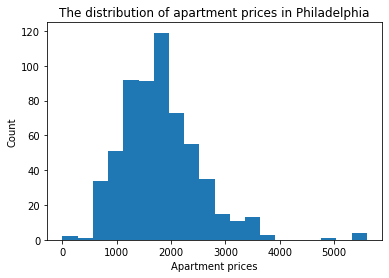

In [19]:
fig1, ax1 = plt.subplots(figsize=(6, 4))
ax1 = plt.hist(results['price'], bins=20)
plt.xlabel('Apartment prices')
plt.ylabel('Count')
plt.title('The distribution of apartment prices in Philadelphia')
plt.show()

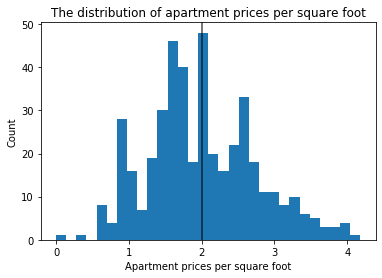

In [20]:
fig2, ax2 = plt.subplots(figsize=(6, 4))
ax2=plt.hist(omitNA['pricePerFt2'],bins=30)
plt.xlabel('Apartment prices per square foot')
plt.ylabel('Count')
plt.title('The distribution of apartment prices per square foot')
plt.axvline(np.mean(omitNA['pricePerFt2']), color='black', alpha=.7)
plt.show()

## 1.6 Comparing prices for different sizes 

Use `altair` to explore the relationship between price, size, and number of bedrooms. Make an interactive scatter plot of price (x-axis) vs. size (y-axis), with the points colored by the number of bedrooms. 

Make sure the plot is interactive (zoom-able and pan-able) and add a tooltip with all of the columns in our scraped data frame.

With this sort of plot, you can quickly see the outlier apartments in terms of size and price.

In [21]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

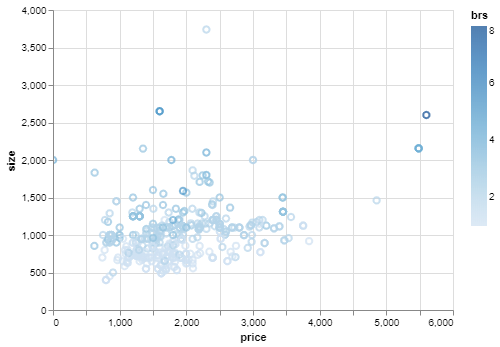

In [22]:
alt.Chart(omitNA).mark_point(size=40).encode(
    x='price',
    y='size',
    color='brs',
    tooltip=omitNA.columns.values.tolist(),
).interactive()

## Part 2: Making an animated map with Datashader

In this part, you will load a "large" data set of your choice and make an animated map of the data using datashader. 

There are several good options available from Open Data Philly, but you are welcome to choose a different source, as long it meets the requirements below.

#### Deliverable
Your final result should be a GIF animating changes in the data set in time. This GIF should be submitted to your repository, and the code used to produce the GIF should be in the notebook.

#### Notes
- For best results with datashader, the dataset should be at least 500,000 rows in size. If you are having difficulty finding a data set large enough, please email me.
- The data must have a date time column, so that you can animate the data in time.
- You can use either dask or pandas to load the data. If you're data set is approaching the size of your machine's memory, you will want to use dask.
- Recommendations from Open Data Philly include: 
    - [311 Requests](https://www.opendataphilly.org/dataset/311-service-and-information-requests)
    - [Crime Incidents](https://www.opendataphilly.org/dataset/crime-incidents)
    - [L&I Code Violations](https://www.opendataphilly.org/dataset/licenses-and-inspections-violations)
    - [Parking Violations](https://www.opendataphilly.org/dataset/parking-violations)
    - [Real Estate Transfers](https://www.opendataphilly.org/dataset/real-estate-transfers)
- You can animate the data by the hour or by the year, e.g., parking violations by hour of day, or parking violations by year.

**Remember: when using datashader your data's coordinates should be in Web Mercator (EPSG coe 3857).**

**Examples:** I've includes several example GIFS in the assignment repository. Note that you are not required to add the city limits boundary to your GIFs, as I have done in the examples.

In [23]:
Philly = (( -75.28,  -74.96), (39.86, 40.14))

from datashader.utils import lnglat_to_meters
x_range, y_range = lnglat_to_meters(Philly[0], Philly[1])

# widht and height
plot_width =400
plot_height = 400

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
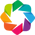

In [24]:
import geopandas as gpd
import holoviews as hv
import hvplot.pandas
import geoviews as gv
from holoviews.operation.datashader import datashade
hv.extension("bokeh")

import datashader as ds
import datashader.transfer_functions as tf

import imageio

In [25]:
mydata = pd.read_csv("https://phl.carto.com/api/v2/sql?q=SELECT+*,+ST_Y(the_geom)+AS+lat,+ST_X(the_geom)+AS+lng+FROM+incidents_part1_part2&filename=incidents_part1_part2&format=csv&skipfields=cartodb_id", 
                     dtype={'psa': 'object', 'hour_':'float64', 'ucr_general': 'float64'}, parse_dates=['dispatch_date_time'])

In [26]:
print('%s Rows' % len(mydata))
print('Columns:', list(mydata.columns))

2672868 Rows
Columns: ['the_geom', 'lng', 'objectid', 'dc_dist', 'psa', 'dispatch_date_time', 'dispatch_date', 'dispatch_time', 'the_geom_webmercator', 'dc_key', 'location_block', 'ucr_general', 'text_general_code', 'point_x', 'point_y', 'lat', 'hour_']


In [27]:
mydata = mydata.loc[mydata['lat'].notnull()]
mydata.head()

the_geom        lng  objectid  \
0  0101000020E6100000F8EEE23F15CB52C0EE0F10A3D2F6... -75.173172       340   
1  0101000020E61000007A4F69ED0BCB52C06E9C1C5786F6... -75.172603       341   
2  0101000020E6100000D3C89D8834CB52C0D5E3A5381AF6... -75.175081       342   
3  0101000020E6100000E51F85042FCB52C058F92B853CF6... -75.174745       343   
4  0101000020E61000007CD13F3D0DCB52C04961410E88F6... -75.172683       344   

   dc_dist psa  dispatch_date_time dispatch_date dispatch_time  \
0        1   1 2015-12-17 07:26:00    2015-12-17      07:26:00   
1        1   1 2015-12-17 11:04:00    2015-12-17      11:04:00   
2        1   1 2015-12-18 22:55:00    2015-12-18      22:55:00   
3        1   1 2015-12-19 00:54:00    2015-12-19      00:54:00   
4        1   1 2015-12-20 01:07:00    2015-12-20      01:07:00   

                                the_geom_webmercator        dc_key  \
0  0101000020110F0000C5A766CE1BEC5FC141FEBD3CBA85...  201501056051   
1  0101000020110F0000F89FBBF80BEC5FC1C77C11BD6585...  201501056080   
2  0101000020110F0000A9DC08F250EC5FC160256000EE84...  201501056360   
3  0101000020110F00008468729347EC5FC1E25B43FC1385...  201501056375   
4  0101000020110F00005BFA2F330EEC5FC18DA369A36785...  201501056502   

             location_block  ucr_general            text_general_code  \
0  1800 BLOCK S CHADWICK ST       1400.0  Vandalism/Criminal Mischief   
1     1500 BLOCK MC KEAN ST       1400.0  Vandalism/Criminal Mischief   
2      2200 BLOCK S 17TH ST       1400.0  Vandalism/Criminal Mischief   
3      2200 BLOCK S 17TH ST       1400.0  Vandalism/Criminal Mischief   
4    S 16TH ST / MC KEAN ST       1400.0  Vandalism/Criminal Mischief   

     point_x    point_y        lat  hour_  
0 -75.173172  39.928303  39.928303    7.0  
1 -75.172603  39.925975  39.925975   11.0  
2 -75.175081  39.922675  39.922675   22.0  
3 -75.174745  39.923722  39.923722    0.0  
4 -75.172683  39.926027  39.926027    1.0

In [28]:
mydata['x'], mydata['y'] = lnglat_to_meters(mydata['lng'], mydata['lat'])
mydata.head()

the_geom        lng  objectid  \
0  0101000020E6100000F8EEE23F15CB52C0EE0F10A3D2F6... -75.173172       340   
1  0101000020E61000007A4F69ED0BCB52C06E9C1C5786F6... -75.172603       341   
2  0101000020E6100000D3C89D8834CB52C0D5E3A5381AF6... -75.175081       342   
3  0101000020E6100000E51F85042FCB52C058F92B853CF6... -75.174745       343   
4  0101000020E61000007CD13F3D0DCB52C04961410E88F6... -75.172683       344   

   dc_dist psa  dispatch_date_time dispatch_date dispatch_time  \
0        1   1 2015-12-17 07:26:00    2015-12-17      07:26:00   
1        1   1 2015-12-17 11:04:00    2015-12-17      11:04:00   
2        1   1 2015-12-18 22:55:00    2015-12-18      22:55:00   
3        1   1 2015-12-19 00:54:00    2015-12-19      00:54:00   
4        1   1 2015-12-20 01:07:00    2015-12-20      01:07:00   

                                the_geom_webmercator        dc_key  \
0  0101000020110F0000C5A766CE1BEC5FC141FEBD3CBA85...  201501056051   
1  0101000020110F0000F89FBBF80BEC5FC1C77C11BD6585...  201501056080   
2  0101000020110F0000A9DC08F250EC5FC160256000EE84...  201501056360   
3  0101000020110F00008468729347EC5FC1E25B43FC1385...  201501056375   
4  0101000020110F00005BFA2F330EEC5FC18DA369A36785...  201501056502   

             location_block  ucr_general            text_general_code  \
0  1800 BLOCK S CHADWICK ST       1400.0  Vandalism/Criminal Mischief   
1     1500 BLOCK MC KEAN ST       1400.0  Vandalism/Criminal Mischief   
2      2200 BLOCK S 17TH ST       1400.0  Vandalism/Criminal Mischief   
3      2200 BLOCK S 17TH ST       1400.0  Vandalism/Criminal Mischief   
4    S 16TH ST / MC KEAN ST       1400.0  Vandalism/Criminal Mischief   

     point_x    point_y        lat  hour_             x             y  
0 -75.173172  39.928303  39.928303    7.0 -8.368239e+06  4.855529e+06  
1 -75.172603  39.925975  39.925975   11.0 -8.368176e+06  4.855191e+06  
2 -75.175081  39.922675  39.922675   22.0 -8.368452e+06  4.854712e+06  
3 -75.174745  39.923722  39.923722    0.0 -8.368414e+06  4.854864e+06  
4 -75.172683  39.926027  39.926027    1.0 -8.368185e+06  4.855199e+06

Plot the crime incidents by hour

In [29]:
from colorcet import fire
def create_image(df, w=plot_width, h=plot_height, cmap=fire):
    
    # create the canvas
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    
    # plot the location of crime, coutning number of passengers
    agg = cvs.points(df, 'x', 'y',  agg=ds.count())
    
    # shade
    img = tf.shade(agg, cmap=fire, how='eq_hist')
    
    # return an PIL image
    return tf.set_background(img, "black").to_pil()

In [30]:
import geopandas as gpd
city_limits = gpd.read_file("http://data.phl.opendata.arcgis.com/datasets/405ec3da942d4e20869d4e1449a2be48_0.geojson")
city_limits = city_limits.to_crs(epsg=3857)

Plot the crime incidents in Philadelphia in 2015 by hour

In [31]:
def convert_to_12hour(hr24):
    """
    Convert from 24 hr to 12 hr.
    """
    from datetime import datetime
    d = datetime.strptime(str(hr24), "%H")
    return d.strftime("%I %p")

In [32]:
def plot_crime_by_hour(fig, data, hour):
    """
    Plot the crime by hour
    """
    # trim to the specific hour
    this_hour = data.loc[data["hour_"] == float(hour)]

    # create the datashaded image
    img = create_image(this_hour)

    # plot the image on a matplotlib axes
    plt.clf()
    ax = fig.gca()
    plt.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
    ax.axis("off")
    city_limits.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=1)

    # add a text label for the hour
    ax.text(
        0.05,
        0.9,
        convert_to_12hour(hour),
        color="white",
        fontsize=35,
        ha="left",
        transform=ax.transAxes,
    )
    
    ax.text(
        0.98,
        0.1,
        "Crime incidents\nin Philadelphia\nby hour\nin 2015",
        color="orange",
        fontsize=25,
        ha="right",
        transform=ax.transAxes,
    )
    ax.text(
        0.97,
        0.06,
        "Xinyi Miao",
        color="white",
        fontsize=13,
        ha="right",
        transform=ax.transAxes,
    )

    # draw the figure and return the image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

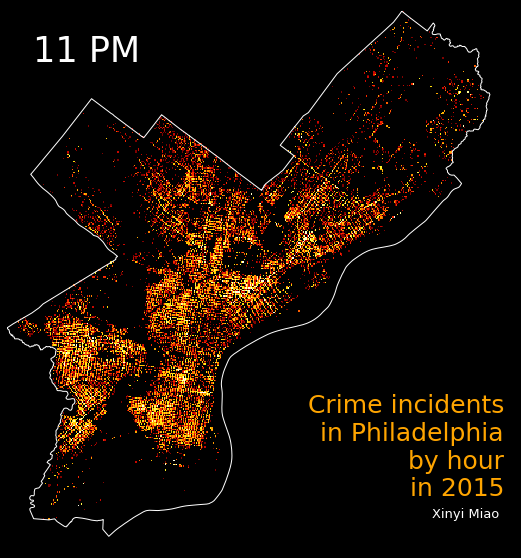

In [33]:
# create a figure
fig, ax = plt.subplots(figsize=(10,10), facecolor='black')

# Create an image for each hour
imgs = []
for hour in range(24):
    img = plot_crime_by_hour(fig, mydata, hour)
    imgs.append(img)
    
# Combing the images for each hour into a single GIF
imageio.mimsave('crimes_hour.gif', imgs, fps=1);

Plot the crime incidents in Philadelphia in 2015 by month

In [34]:
mydata['dispatch_date']=pd.to_datetime(mydata['dispatch_date'],format = "%Y-%m-%d")

In [35]:
mydata['month'] = mydata['dispatch_date'].dt.month

In [36]:
def convert_month(month):
    d = datetime.strptime(str(month), "%m")
    return d.strftime("%B")

In [37]:
def plot_crime_by_month(fig, data, month):
    """
    Plot the crime by month
    """
    # trim to the specific month
    this_month = data.loc[data["month"] == month]

    # create the datashaded image
    img = create_image(this_month,w=plot_width, h=plot_height, cmap=fire)

    # plot the image on a matplotlib axes
    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
    ax.axis("off")
    city_limits.plot(ax=ax, facecolor="none", edgecolor="white",linewidth=1)

    # add a text label for the month
    ax.text(
        0.05,
        0.9,
        convert_month(month),
        color="white",
        fontsize=35,
        ha="left",
        transform=ax.transAxes,
    )
    
    ax.text(
        0.98,
        0.1,
        "Crime incidents\nin Philadelphia\nby month\nin 2015",
        color="orange",
        fontsize=25,
        ha="right",
        transform=ax.transAxes,
    )
    ax.text(
        0.97,
        0.06,
        "Xinyi Miao",
        color="white",
        fontsize=13,
        ha="right",
        transform=ax.transAxes,
    )

    # draw the figure and return the image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

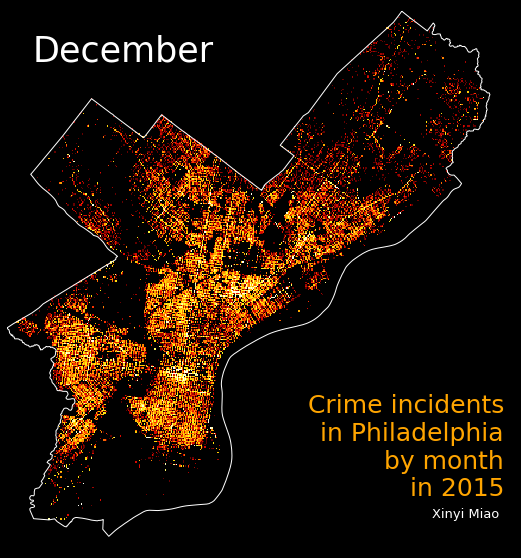

In [38]:
# create a figure
fig, ax = plt.subplots(figsize=(10,10), facecolor='black')

# Create an image for each month
imgs = []
for month in range(1,13,1):
    img = plot_crime_by_month(fig, mydata, month)
    imgs.append(img)

# Combing the images for each hour into a single GIF
imageio.mimsave('crimes_month.gif', imgs, fps=1);